In [1]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp, cle_for_resmlp_v3
# from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels, get_linear_layers

org_model = resmlp_24_v4(pretrained=True).eval()
# model1 = resmlp_24(pretrained=True).eval()
# model2 = resmlp_24_v3(pretrained=True).eval()
# print(same_output(model1, org_model, eps=1e-5))

# model_norm = resmlp_24_norm(pretrained=False).eval()
# model_norm.load_state_dict(torch.load("771.pth")["model"])
# qmodel = q_resmlp_v3(model)

# # test CLE
# org_model = resmlp_24(pretrained=False).eval()
# org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# model = resmlp_24(pretrained=False).eval()
# model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# cle_for_resmlp(model)
# qmodel = q_resmlp_v3(model1)


c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Error(s) in loading state_dict for resmlp_models:
	Missing key(s) in state_dict: "norm.alpha", "norm.beta". 
	Unexpected key(s) in state_dict: "blocks.0.norm2.bias", "blocks.1.norm2.bias", "blocks.2.norm2.bias", "blocks.3.norm2.bias", "blocks.4.norm2.bias", "blocks.5.norm2.bias", "blocks.6.norm2.bias", "blocks.7.norm2.bias", "blocks.8.norm2.bias", "blocks.9.norm2.bias", "blocks.10.norm2.bias", "blocks.11.norm2.bias", "blocks.12.norm2.bias", "blocks.13.norm2.bias", "blocks.14.norm2.bias", "blocks.15.norm2.bias", "blocks.16.norm2.bias", "blocks.17.norm2.bias", "blocks.18.norm2.bias", "blocks.19.norm2.bias", "blocks.20.norm2.bias", "blocks.21.norm2.bias", "blocks.22.norm2.bias", "blocks.23.norm2.bias", "norm.weight", "norm.bias". 

In [40]:
v1 = torch.load("ResMLP_S24_ReLU_fp32_80.602.pth")

new_model_dict = {}

for k, v in model1.state_dict().items():
    if "blocks" not in k:
        new_model_dict[k] = v


for i in range(24):
    gamma_w = None
    norm_w = None
    norm_b = None
    attn_w = None
    attn_b = None
    for k, v in model1.blocks[i].state_dict().items():
        # print(k)
        if "norm1.weight" in k:
            norm_w = v
        elif "norm1.bias" in k:
            norm_b = v
        elif "attn.weight" in k:
            attn_w = v
        elif "attn.bias" in k:
            attn_b = v
        elif "gamma_1.weight" in k:
            gamma_w = v
        else:
            new_model_dict[f"blocks.{i}.{k}"] = v
        
    new_model_dict[f"blocks.{i}.inner.weight"] = torch.diag(norm_w * gamma_w)
    new_model_dict[f"blocks.{i}.inner.bias"] = norm_b.repeat(196,1) @ gamma_w + torch.inverse(attn_w) @ attn_b.repeat(384,1).T @ gamma_w
    new_model_dict[f"blocks.{i}.outer.weight"] = attn_w
    
torch.save(new_model_dict, "ResMLP_S24_ReLU_v4.pth")


In [42]:
# for k, v in model1.state_dict().items():
#     print(k)

for k in new_model_dict:
    print(k)

patch_embed.proj.weight
patch_embed.proj.bias
norm.weight
norm.bias
head.weight
head.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.0.gamma_2.weight
blocks.0.inner.weight
blocks.0.inner.bias
blocks.0.outer.weight
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.1.gamma_2.weight
blocks.1.inner.weight
blocks.1.inner.bias
blocks.1.outer.weight
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.2.gamma_2.weight
blocks.2.inner.weight
blocks.2.inner.bias
blocks.2.outer.weight
blocks.3.norm2.weight
blocks.3.norm2.bias
blocks.3.mlp.fc1.weight
blocks.3.mlp.fc1.bias
blocks.3.mlp.fc2.weight
blocks.3.mlp.fc2.bias
blocks.3.gamma_2.weight
blocks.3.inner.weight
blocks.3.inner.bias
blocks.3.outer.weight
blocks.4.norm2.weight


In [45]:
new_model_dict['norm.weight'].shape

torch.Size([384, 384])

([<matplotlib.axis.XTick at 0x1aa2bcbd310>,
 [Text(1, 0, '0-inner'), Text(2, 0, '0-mlp.fc1'), Text(3, 0, '0-mlp.fc2')])

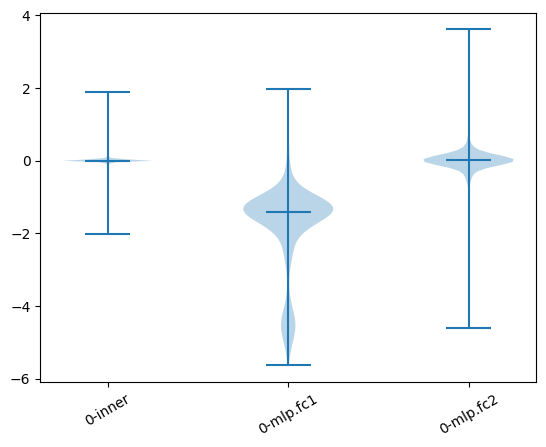

In [22]:
model_layers = []
for i in range(0, 1):
    todo_layer = model2.blocks[i]
    model_layers.append(get_linear_layers(todo_layer, specify_names=None, prefix=f"{i}-"))
# print(model_layers[0].weight.detach().numpy().flatten())

data = []
labels = []
for layer in model_layers:
    for n, m in layer:
        val = m.bias
        if val is not None:
            data.append(val[val.nonzero(as_tuple=True)].detach().numpy().flatten())
            labels.append(n)

plt.violinplot(data, showmedians=True, showextrema=True)
plt.xticks(range(1, len(labels) + 1), labels, rotation=30)

{'whiskers': [<matplotlib.lines.Line2D at 0x1aa2be1f4c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1aa2be1fa00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1aa2be1f220>,
 'medians': [<matplotlib.lines.Line2D at 0x1aa2be1ff40>,
 'fliers': [],
 'means': []}

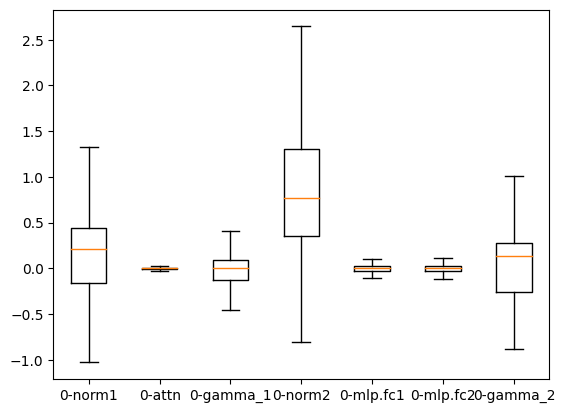

In [23]:
model_layers = []
for i in range(0, 1):
    todo_layer = model1.blocks[i]
    model_layers.append(get_linear_layers(todo_layer, specify_names=None, prefix=f"{i}-"))
# print(model_layers[0].weight.detach().numpy().flatten())

data = []
labels = []
for layer in model_layers:
    for n, m in layer:
        val = m.weight
        data.append(val[val.nonzero(as_tuple=True)].detach().numpy().flatten())
        labels.append(n)

plt.boxplot(data, labels=labels, showfliers=False)

In [24]:
l1 = model1.blocks[5].norm1.eval()
l2 = model1.blocks[5].attn.eval()
l3 = model1.blocks[5].gamma_1.eval()

print(l1.weight.shape, l2.weight.shape, l3.weight.shape)

x = torch.randn(1, 196, 384)

# F.linear(l1.weight, l2.weight)
# l1(x)

# fuse the three linears

W1 = l1.weight * l3.weight
B1 = l1.bias.repeat(196,1)@ l3.weight + torch.inverse(l2.weight) @ l2.bias.repeat(384,1).T @ l3.weight

W2 = l2.weight
# weight = l2.weight @ l1.weight
# bias = l2.bias + F.linear(l2.weight, l1.bias)

out1 = l3(l2(l1(x).transpose(1,2)).transpose(1,2))
out2 = W2 @ (x @ W1 + B1)
torch.allclose(out1, out2, atol=1e-4)

torch.Size([384, 384]) torch.Size([196, 196]) torch.Size([384, 384])


True

In [25]:
r1 = W1.abs().max()
r2 = W2.abs().max()
sT = torch.sqrt(r1*r2)/r2

W2_new = W2 * sT
W1_new = W1 / sT
B1_new = B1 / sT

print(sT)

out3 = W2_new @ (x @ W1_new + B1_new)
torch.allclose(out3, out2, atol=1e-5)

tensor(1.9382, grad_fn=<DivBackward0>)


True

In [26]:
print(W1_new.abs().max(), W2_new.abs().max())

tensor(1.3299, grad_fn=<MaxBackward1>) tensor(1.3299, grad_fn=<MaxBackward1>)


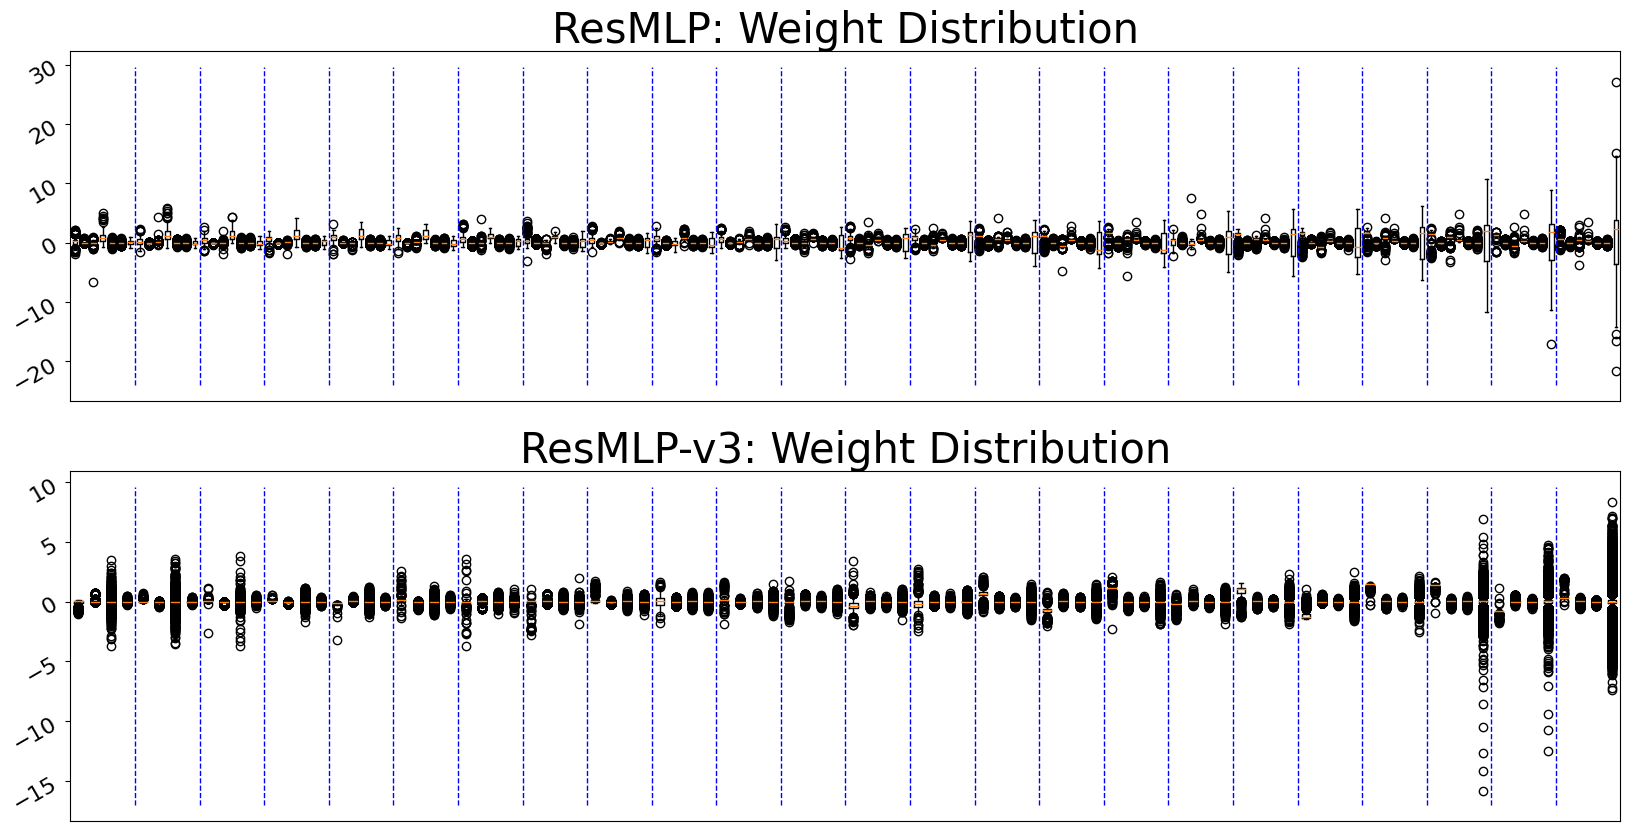

In [27]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(model1, 0, 23, name="ResMLP: Weight Distribution", ax=ax[0], type="weight")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(model2, 0, 23, name="ResMLP-v3: Weight Distribution", ax=ax[1], type="weight")

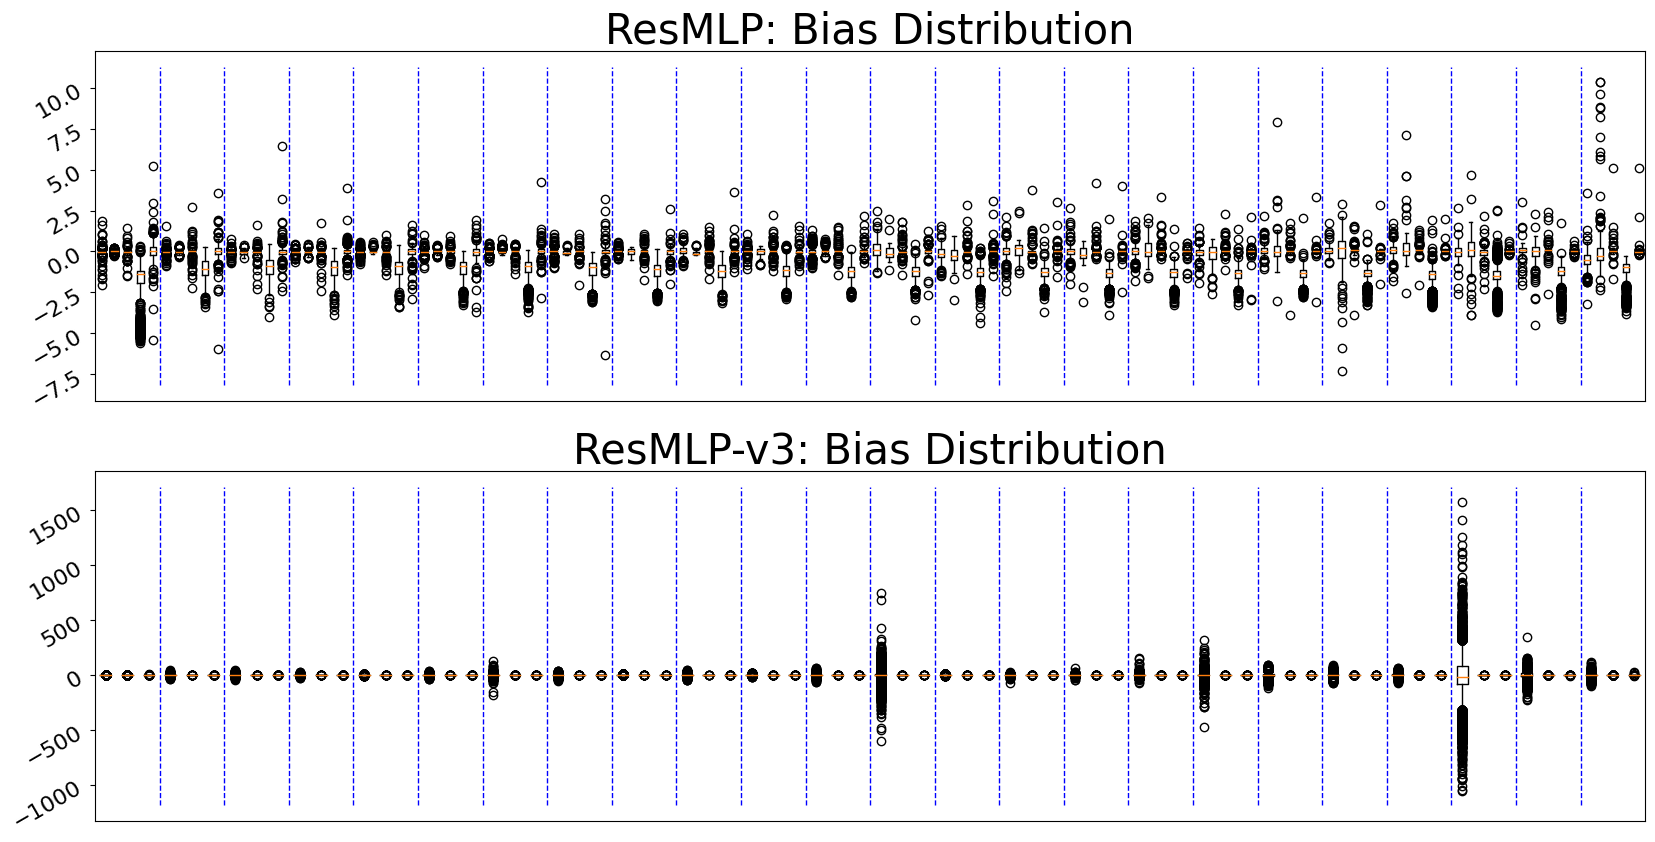

In [28]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(model1, 0, 23, name="ResMLP: Bias Distribution", ax=ax[0], type="bias")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(model2, 0, 23, name="ResMLP-v3: Bias Distribution", ax=ax[1], type="bias")

Loading a small piece of training data...
Calibrating...


KeyboardInterrupt: 

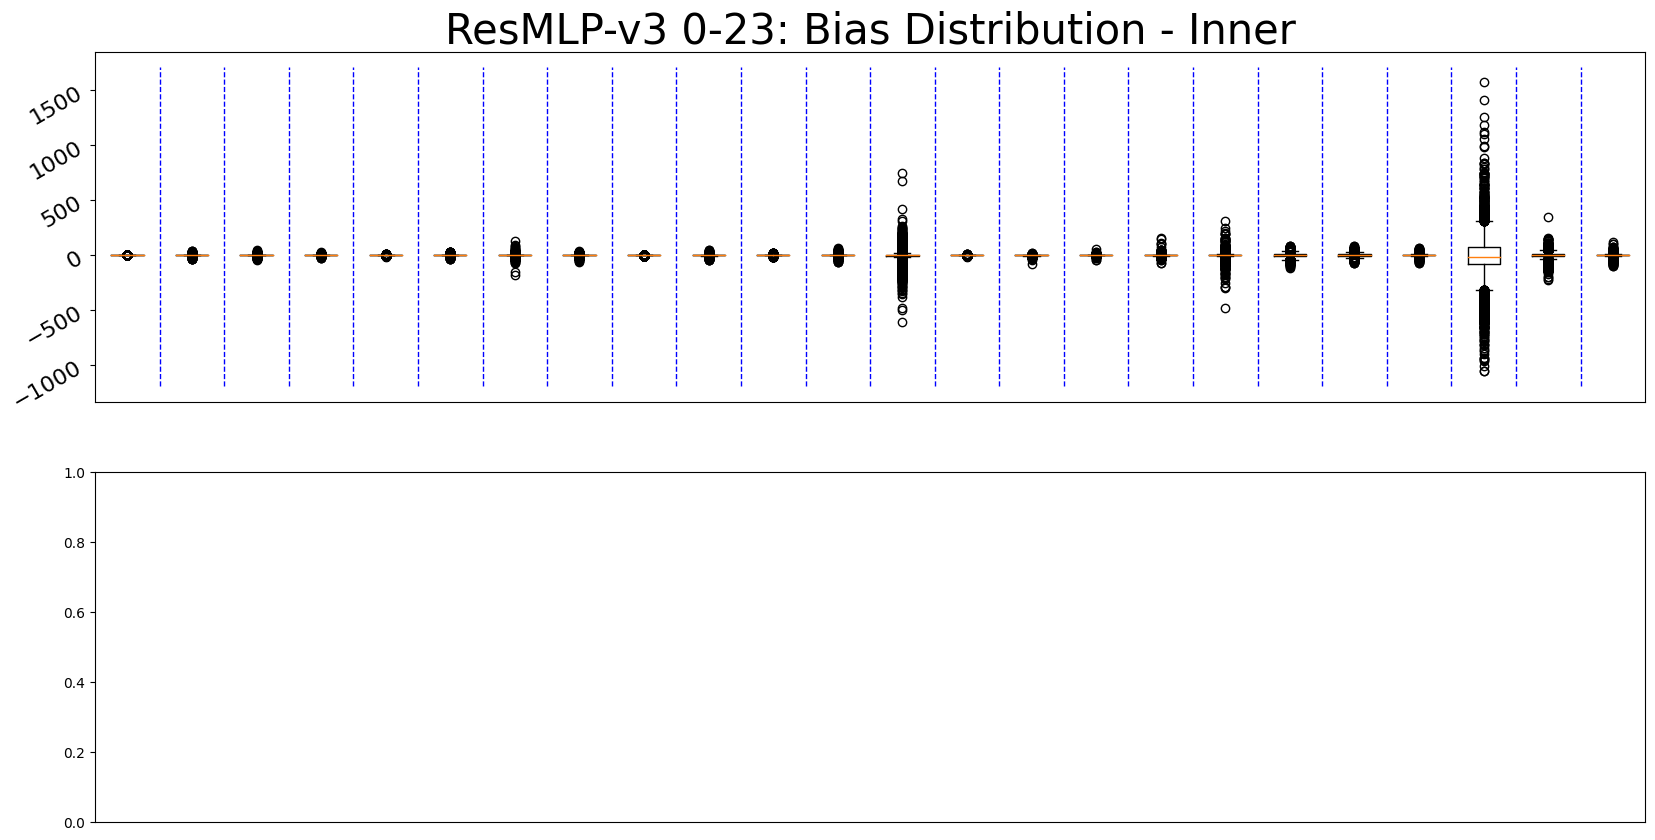

In [29]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model2.cpu()
layer_dist(model2, 0, 23, name="ResMLP-v3 0-23: Bias Distribution - Inner", show_layers=["inner"], ax=ax[0], type="bias")

model2.cuda()
# cle_for_resmlp_v3(model2)
# layer_dist(model2, 0, 10, name="ResMLP-v3: Bias Distribution - Others", show_layers=["outer", "mlp.fc1", "mlp.fc2"], ax=ax[1], type="bias")
act_dist(model2, 0, 23, name='ResMLP-v3 0-23: Activation - Inner', show_layers=["inner"], ax=ax[1], real_sim=True)

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.336 ( 9.336)
Calibrate: [10/21]	Time  1.742 ( 2.388)
Calibrate: [20/21]	Time  0.193 ( 1.986)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.337 ( 9.337)
Calibrate: [10/21]	Time  2.128 ( 2.765)
Calibrate: [20/21]	Time  0.274 ( 2.363)


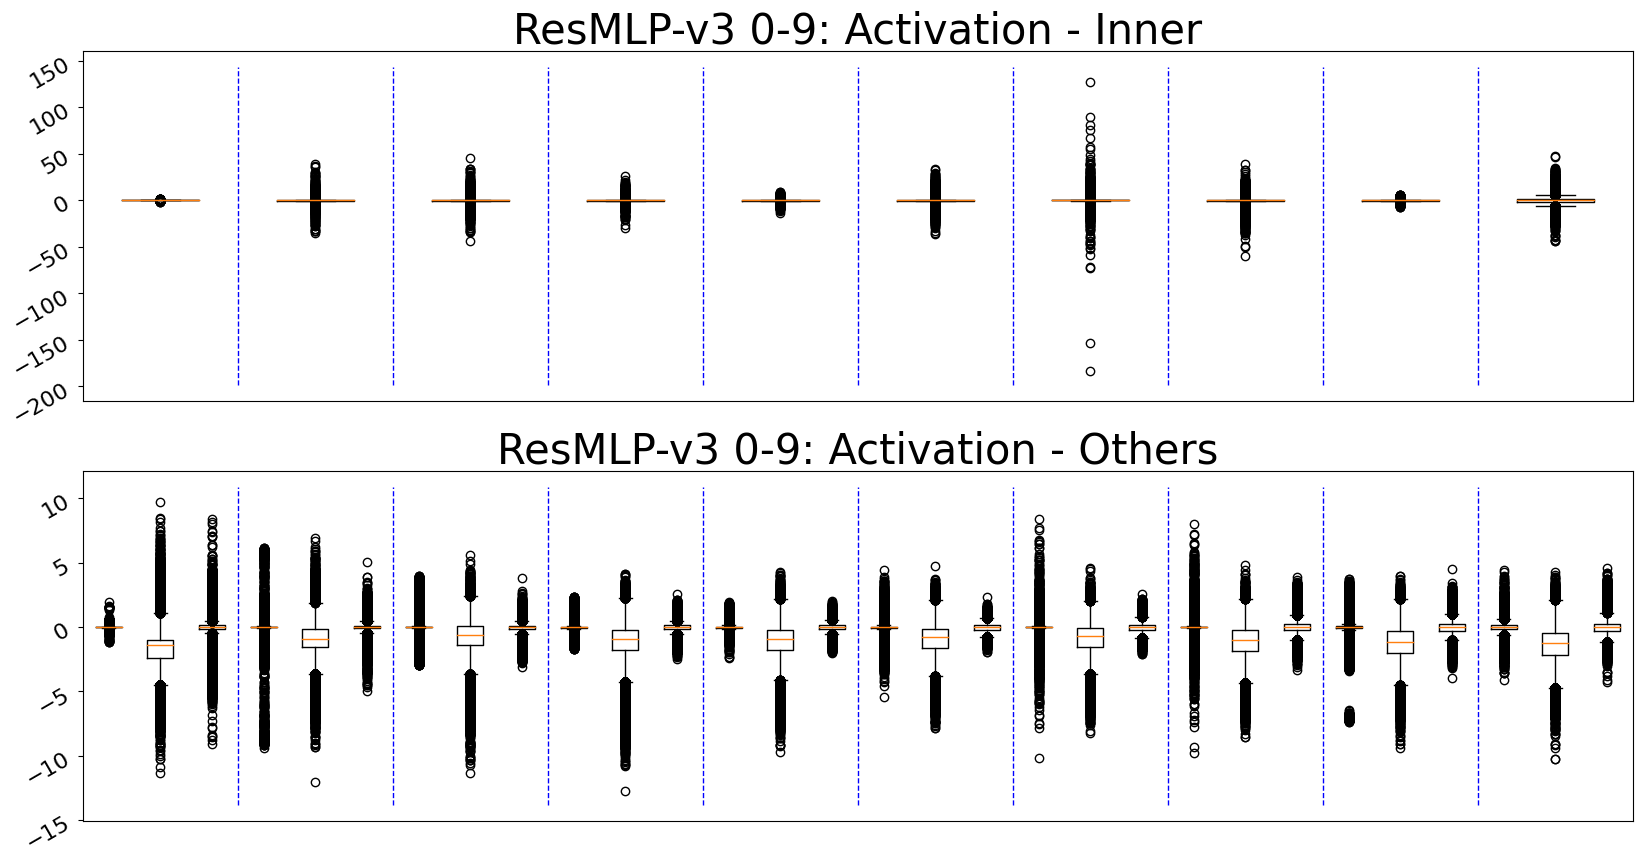

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model2.cuda()
act_dist(model2, 0, 9, name='ResMLP-v3 0-9: Activation - Inner', show_layers=["inner"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
model2.cuda()
act_dist(model2, 0, 9, name='ResMLP-v3 0-9: Activation - Others', show_layers=["outer", "mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model1.cuda()
act_dist(model1, 0, 23, name='ResMLP: Activation Distribution', show_layers=["inner", "mlp.fc2"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
model2.cuda()
act_dist(model2, 0, 23, name='ResMLP-v3: Activation Distribution', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)